In [2]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


def main():
    # 1. Load HealthStory dataset
    df = pd.read_csv("fakehealth_healthstory.csv")

    # Make sure there are no missing texts
    df["text"] = df["text"].fillna("")

    X = df["text"]
    y = df["label"]          # 0 = fake, 1 = real

    # 2. Train / test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        stratify=y,
        random_state=42,
    )

    # 3. Define models
    models = {
        "Logistic Regression": LogisticRegression(
            max_iter=1000,
            n_jobs=-1,
            class_weight="balanced",  # helpful if labels are imbalanced
        ),
        "Linear SVM": LinearSVC(
            class_weight="balanced",
        ),
        "Random Forest": RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            n_jobs=-1,
            random_state=42,
        ),
        "KNN": KNeighborsClassifier(
            n_neighbors=5,
        ),
        "Multinomial NB": MultinomialNB(),
        "Decision Tree": DecisionTreeClassifier(
            random_state=42,
        ),
        "XGBoost": XGBClassifier(
            n_estimators=300,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",
            eval_metric="logloss",
            n_jobs=-1,
            random_state=42,
            use_label_encoder=False,
        ),
    }

    # 4. Shared TF-IDF vectorizer (word + bigram)
    # We'll put this inside each pipeline so everything is clean & self-contained
    def make_pipeline(clf):
        return Pipeline(
            steps=[
                (
                    "tfidf",
                    TfidfVectorizer(
                        ngram_range=(1, 2),
                        min_df=5,
                        max_df=0.9,
                        strip_accents="unicode",
                    ),
                ),
                ("clf", clf),
            ]
        )

    results = []

    # 5. Train & evaluate each model
    for name, clf in models.items():
        print("=" * 60)
        print(f"Training {name}...")
        pipe = make_pipeline(clf)
        pipe.fit(X_train, y_train)

        y_pred = pipe.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)          # binary F1 (for class 1)
        f1_macro = f1_score(y_test, y_pred, average="macro")

        print(f"\n{name} – Accuracy: {acc:.4f}, F1 (macro): {f1_macro:.4f}")
        print("\nClassification report (0=fake, 1=real):")
        print(classification_report(y_test, y_pred, digits=4))

        results.append(
            {
                "model": name,
                "accuracy": acc,
                "f1_macro": f1_macro,
                "f1_real_class": f1,
            }
        )

    # 6. Comparison table
    print("\n" + "#" * 60)
    print("Overall comparison")
    results_df = pd.DataFrame(results).sort_values(
        by="f1_macro", ascending=False
    )
    print(results_df.to_string(index=False))

    # Optional: save the table
    results_df.to_csv("healthstory_model_comparison.csv", index=False)
    print("\nSaved comparison to healthstory_model_comparison.csv")


if __name__ == "__main__":
    main()


Training Logistic Regression...

Logistic Regression – Accuracy: 0.6347, F1 (macro): 0.5573

Classification report (0=fake, 1=real):
              precision    recall  f1-score   support

           0     0.3465    0.4023    0.3723        87
           1     0.7658    0.7203    0.7424       236

    accuracy                         0.6347       323
   macro avg     0.5562    0.5613    0.5573       323
weighted avg     0.6528    0.6347    0.6427       323

Training Linear SVM...

Linear SVM – Accuracy: 0.5944, F1 (macro): 0.5344

Classification report (0=fake, 1=real):
              precision    recall  f1-score   support

           0     0.3167    0.4368    0.3671        87
           1     0.7586    0.6525    0.7016       236

    accuracy                         0.5944       323
   macro avg     0.5376    0.5447    0.5344       323
weighted avg     0.6396    0.5944    0.6115       323

Training Random Forest...

Random Forest – Accuracy: 0.7028, F1 (macro): 0.4887

Classification re

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [16:14:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost – Accuracy: 0.7121, F1 (macro): 0.5387

Classification report (0=fake, 1=real):
              precision    recall  f1-score   support

           0     0.4211    0.1839    0.2560        87
           1     0.7509    0.9068    0.8215       236

    accuracy                         0.7121       323
   macro avg     0.5860    0.5453    0.5387       323
weighted avg     0.6620    0.7121    0.6692       323


############################################################
Overall comparison
              model  accuracy  f1_macro  f1_real_class
Logistic Regression  0.634675  0.557349       0.742358
            XGBoost  0.712074  0.538749       0.821497
         Linear SVM  0.594427  0.534372       0.701595
      Decision Tree  0.628483  0.509665       0.751037
                KNN  0.634675  0.492409       0.761134
      Random Forest  0.702786  0.488722       0.819549
     Multinomial NB  0.730650  0.433139       0.843806

Saved comparison to healthstory_model_comparison.csv


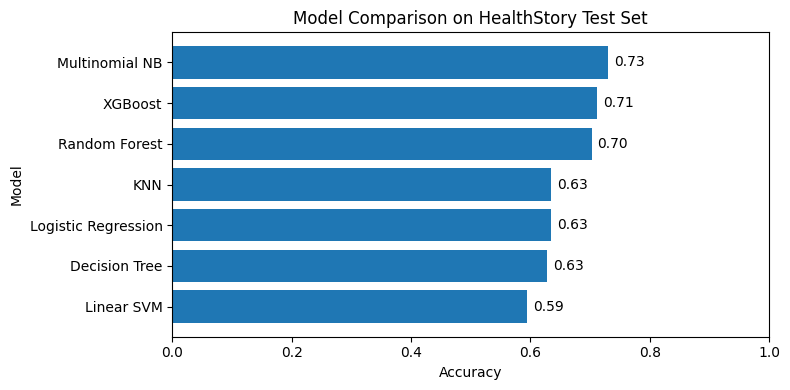

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the comparison results
df = pd.read_csv("healthstory_model_comparison.csv")

# 2. Sort by accuracy so the best model is at the top of the chart
df_sorted = df.sort_values("accuracy", ascending=True)

# 3. Make the bar plot
plt.figure(figsize=(8, 4))
plt.barh(df_sorted["model"], df_sorted["accuracy"])

plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Comparison on HealthStory Test Set")
plt.xlim(0, 1)  # accuracy between 0 and 1

# 4. Optional: add accuracy values at the end of each bar
for i, (acc, model) in enumerate(zip(df_sorted["accuracy"], df_sorted["model"])):
    plt.text(acc + 0.01, i, f"{acc:.2f}", va="center")

plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
from tabulate import tabulate

# Load the comparison results you already saved
df = pd.read_csv("healthstory_model_comparison.csv")

# If you also want AUC, uncomment this later when computed
# df["AUC"] = [...]

# Reorder columns to mimic the paper style
df_table = df[["model", "accuracy", "f1_macro"]].copy()
df_table.columns = ["Model", "Accuracy", "F1"]

# Format decimals to 3 places like paper
df_table["Accuracy"] = df_table["Accuracy"].round(3)
df_table["F1"] = df_table["F1"].round(3)

print("\n=== Fake News Detection Performance (HealthStory) ===")
print(tabulate(df_table, headers="keys", tablefmt="psql"))



=== Fake News Detection Performance (HealthStory) ===
+----+---------------------+------------+-------+
|    | Model               |   Accuracy |    F1 |
|----+---------------------+------------+-------|
|  0 | Logistic Regression |      0.635 | 0.557 |
|  1 | XGBoost             |      0.712 | 0.539 |
|  2 | Linear SVM          |      0.594 | 0.534 |
|  3 | Decision Tree       |      0.628 | 0.51  |
|  4 | KNN                 |      0.635 | 0.492 |
|  5 | Random Forest       |      0.703 | 0.489 |
|  6 | Multinomial NB      |      0.731 | 0.433 |
+----+---------------------+------------+-------+


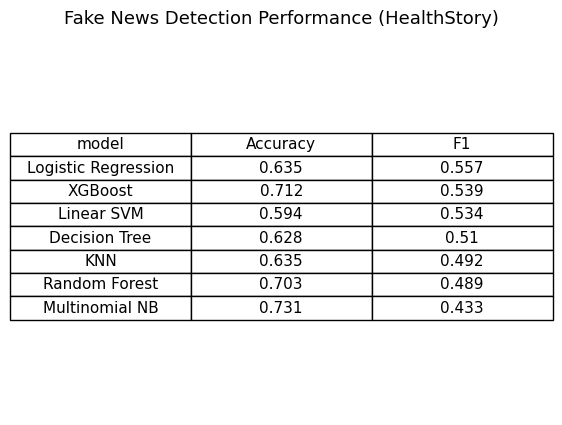

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df = pd.read_csv("healthstory_model_comparison.csv")

# Format values like the paper
df_plot = df.copy()
df_plot["Accuracy"] = df_plot["accuracy"].round(3)
df_plot["F1"] = df_plot["f1_macro"].round(3)

# Keep only needed columns
df_plot = df_plot[["model", "Accuracy", "F1"]]

# Create figure
fig, ax = plt.subplots(figsize=(7, len(df_plot) * 0.7))
ax.axis("off")

table = ax.table(
    cellText=df_plot.values,
    colLabels=df_plot.columns,
    loc="center",
    cellLoc="center"
)

# Style like a research paper
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.4)

plt.title("Fake News Detection Performance (HealthStory)", fontsize=13, pad=10)
plt.show()
